In [4]:
import pandas as pd
import networkx as nx
import numpy as np
import os
import urllib
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy import stats 

# load config and extract variables
import config
DATA_PATH = config.PATH_TO_DATA

### Loading and Preparing the Data
Load and clean up the paths, load into weighted graph structure etc.

#### Load Data

In [5]:
# load in all data (except wikipedia articles)
finished_paths = pd.read_csv(os.path.join(DATA_PATH, "wikispeedia_paths-and-graph/paths_finished.tsv"), sep='\t', skiprows=15, names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])
unfinished_paths = pd.read_csv(os.path.join(DATA_PATH, "wikispeedia_paths-and-graph/paths_unfinished.tsv"), sep='\t', skiprows=16, names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"])
edges = pd.read_csv(os.path.join(DATA_PATH, "wikispeedia_paths-and-graph/links.tsv"), sep='\t', skiprows=15, names=["start", "end"], encoding="utf-8")
articles = pd.read_csv(os.path.join(DATA_PATH, "wikispeedia_paths-and-graph/articles.tsv"), sep='\t', skiprows=12, names=["article"], encoding="utf-8")
categories = pd.read_csv(os.path.join(DATA_PATH, "wikispeedia_paths-and-graph/categories.tsv"), sep='\t', skiprows=13, names=["article", "category"], encoding="utf-8")
shortest_paths = np.genfromtxt(os.path.join(DATA_PATH, "wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt"), delimiter=1, dtype=np.uint8)

#### Clean up

In [6]:
# Clean up edge list
display(edges.head())
edges["start"] = edges.start.apply(urllib.parse.unquote)
edges["end"] = edges.end.apply(urllib.parse.unquote)
display(edges.head())

,start,end
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Monarchy
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Orkney


,start,end
0,Áedán_mac_Gabráin,Great_Britain
1,Áedán_mac_Gabráin,Ireland
2,Áedán_mac_Gabráin,Isle_of_Man
3,Áedán_mac_Gabráin,Monarchy
4,Áedán_mac_Gabráin,Orkney


In [7]:
# format datetime as datetime object
finished_paths["datetime"] = finished_paths.timestamp.apply(datetime.datetime.fromtimestamp)
unfinished_paths["datetime"] = unfinished_paths.timestamp.apply(datetime.datetime.fromtimestamp)
display(unfinished_paths.head())

,hashedIpAddress,timestamp,durationInSec,path,target,type,datetime
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,2011-02-07 06:02:15
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,2011-02-07 06:14:11
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,2011-02-07 16:00:19
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,2011-02-07 17:06:01
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2011-02-07 18:18:25


In [8]:
# clean up url encoding for articles
display(articles.head())
articles["article"] = articles.article.apply(urllib.parse.unquote)
display(articles.head())

,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


In [9]:
# clean up url encoding for categories
display(categories.head())
categories["article"] = categories.article.apply(urllib.parse.unquote)
display(categories.head())

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists


In [10]:
# merge articles and categories
articles_categories = pd.merge(articles, categories, how="left", on="article")
display(articles_categories.head())
# 6 articles without category!
print("Merge introduced {} NAs in category columns:".format(articles_categories.category.isna().sum()))
articles_categories[articles_categories.category.isna()]

,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists


Merge introduced 6 NAs in category columns:


,article,category
1360,Directdebit,NaN
1385,Donation,NaN
1811,Friend_Directdebit,NaN
3670,Pikachu,NaN
4342,Sponsorship_Directdebit,NaN
5141,Wowpurchase,NaN


In [11]:
# Convert paths to a readable format (lists)

finished_paths_readable = finished_paths.copy()
finished_paths_readable["readable_path"] = finished_paths_readable["path"].apply(lambda x: x.split(";"))
finished_paths_readable["readable_path"] = finished_paths_readable["readable_path"].apply(lambda x: [urllib.parse.unquote(y) for y in x])

unfinished_paths_readable = unfinished_paths.copy()
unfinished_paths_readable["readable_path"] = unfinished_paths_readable["path"].apply(lambda x: x.split(";"))
unfinished_paths_readable["readable_path"] = unfinished_paths_readable["readable_path"].apply(lambda x: [urllib.parse.unquote(y) for y in x])
unfinished_paths_readable["target"] = unfinished_paths_readable["target"].apply(urllib.parse.unquote)

In [12]:
# functions to get all links between articles
from itertools import tee
def pairwise(iterable):
    # from python docs - will be introduced in version 3.10
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


def get_all_links(df, path_colname="path"):
    edge_counter = {}
    for _, row in df.iterrows():
        links = row['path'].split(';')
        
        edges = list(pairwise(links))

        for edge in edges:
            if edge in edge_counter:
                edge_counter[edge] += 1
            else:
                edge_counter[edge] = 1

    out = pd.Series(edge_counter).reset_index()
    out.columns = ["source", "target", "weight"]
    return out



In [13]:
# get all finished links
finished_links = get_all_links(finished_paths)
finished_links.sort_values(by="weight", ascending=False) # TODO: what is up with these <<< signs?


,source,target,weight
66,<,<,4971
8550,Communication,Telephone,533
25,North_America,United_States,492
579,Animal,Mammal,487
2127,Lion,Zebra,472
...,...,...,...
34539,Latin_America,Guyana,1
34538,Wine,Latin_America,1
34532,Crow,Dove,1
34530,Symmetry,Physics,1


In [14]:
# get all unfinished links
unfinished_links = get_all_links(unfinished_paths)
unfinished_links.sort_values(by="weight", ascending=False) # TODO: what is up with these <<< signs?


,source,target,weight
63,<,<,3814
5155,Pyramid,Mexico,278
5209,Brain,Computer_science,222
392,Animal,Mammal,187
159,<,United_States,171
...,...,...,...
18326,Electromagnetic_radiation,Gauss%27s_law,1
18324,History_of_computing_hardware,History_of_the_Internet,1
18323,Scurvy,Pellagra,1
18322,River,Germany,1


count    2788.000000
mean        1.495696
std        13.778984
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       240.000000
dtype: float64

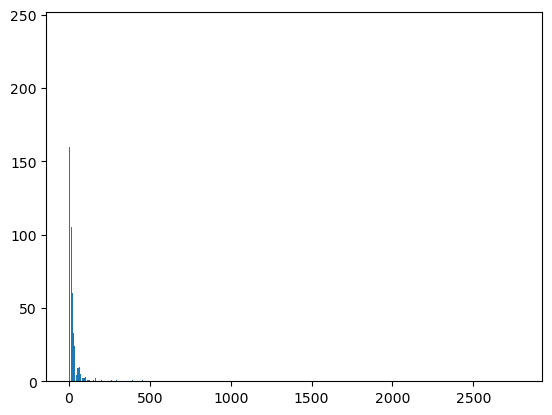

In [15]:
# create newtorkx graph from finished paths
finished_graph = nx.from_pandas_edgelist(finished_links,source="source", target="target", edge_attr="weight")
hist = nx.degree_histogram(finished_graph)
plt.bar(range(len(hist)), hist)
pd.Series(hist).describe()

count    2284.000000
mean        1.761821
std        18.526944
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       363.000000
dtype: float64

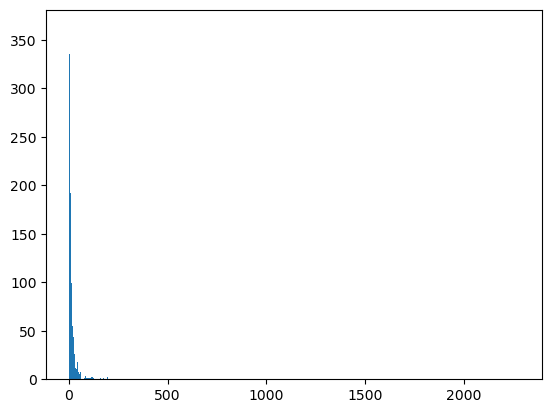

In [16]:
# create newtorkx graph from unfinished paths
unfinished_graph = nx.from_pandas_edgelist(unfinished_links,source="source", target="target", edge_attr="weight")
hist = nx.degree_histogram(unfinished_graph)
plt.bar(range(len(hist)), hist)
pd.Series(hist).describe()

In [17]:
# Seeing which categories are most represented in articles

broad_categories = categories.copy()
broad_categories["broad_category"] = broad_categories["category"].apply(lambda x: x.split(".")[1])

count_articles = broad_categories.groupby("broad_category").size()

print("Below shows how many articles each of the broad categories are represented by")
display(count_articles)

Below shows how many articles each of the broad categories are represented by


broad_category
Art                          38
Business_Studies             88
Citizenship                 224
Countries                   229
Design_and_Technology       254
Everyday_life               374
Geography                  1084
History                     545
IT                           85
Language_and_literature     196
Mathematics                  45
Music                        97
People                      689
Religion                    134
Science                    1122
dtype: int64

In [18]:
# Create dictionaries for easy discovery of what categories an article belongs to
article_to_category = {}
article_to_broad_category = {}
for i in range(len(broad_categories)):
    if broad_categories.iloc[i]["article"] in article_to_category:
        article_to_category[broad_categories.iloc[i]["article"]].append(broad_categories.iloc[i]["category"])
        article_to_broad_category[broad_categories.iloc[i]["article"]].append(broad_categories.iloc[i]["broad_category"])
    else:
        article_to_category[broad_categories.iloc[i]["article"]] = [broad_categories.iloc[i]["category"]]
        article_to_broad_category[broad_categories.iloc[i]["article"]] = [broad_categories.iloc[i]["broad_category"]]

# Backclick analysis

In [19]:
def get_backclicked_pages(path):
    """
    Returns a list of all the pages that were backclicked on in a path l.
    """
    if "<" in path:
        s = []
        res = []
        for i in range(len(path)):
            if path[i] == "<":
                res.append(s.pop())
            else:
                s.append(path[i])
        return res
    else:
        return []
    

def get_quitted_page(path):
    """
    Return the page on which the user quit the path.
    """
    if path is None:
        return pd.NA
    else:
        if path[-1] != "<":
            return path[-1]
        else:
            clean_path = []
            for page in path:
                if page != "<":
                    clean_path.append(page)
                else:
                    clean_path.pop()
            return clean_path[-1]


#### Let's now analyse the quitting rate of every single player in each category and compare it to the quitting rate of the player
####

## Filtering and pre-processing

In [27]:
# Copy data (we're gonna filter out some stuff)
finished = finished_paths_readable.copy(deep=True)
unfinished = unfinished_paths_readable.copy(deep=True)


# Keep only data matching the same period (unfinished path were not recorded before 2011-02-07)
finished = finished[finished["datetime"] >= unfinished.sort_values(by="datetime").datetime[0]]

# Keep only unfinished games where the reason is "restart"
# TODO: see whether this makes the difference or not
unfinished = unfinished[unfinished["type"] == "restart"]

# Keep only games referring to path longer than l
path = 1
unfinished = unfinished[unfinished["readable_path"].apply(lambda x: len(x) > path)]
finished = finished[finished["readable_path"].apply(lambda x: len(x) > path)]


# Keep only players that played overall at least n games
n = 10
considered_players = pd.concat([finished[["hashedIpAddress", "datetime"]], unfinished[["hashedIpAddress", "datetime"]]])
considered_players = considered_players.groupby(by="hashedIpAddress").size().reset_index(name="num_games")
considered_players = considered_players[considered_players["num_games"] >= n]

finished = pd.merge(left=finished, right=considered_players, how="inner", on="hashedIpAddress")
unfinished = pd.merge(left=unfinished, right=considered_players, how="inner", on="hashedIpAddress")

print("{} players played at least {} games longer than {} pages.".format(len(considered_players), n, path))


730 players played at least 10 games longer than 1 pages.


# 1. Quitting rate distribution

#### Let's visualize the distribution of quitting probability

In [28]:
quitting_rates = pd.DataFrame({
    "played_games": pd.concat([finished["hashedIpAddress"], unfinished["hashedIpAddress"]], ignore_index=True).value_counts(),
    "quitted_games": unfinished["hashedIpAddress"].value_counts(),
}).reset_index()

quitting_rates["quitted_games"].fillna(0, inplace=True)
quitting_rates["quit_rate"] = quitting_rates["quitted_games"] / quitting_rates["played_games"]

<Axes: xlabel='quit_rate', ylabel='Count'>

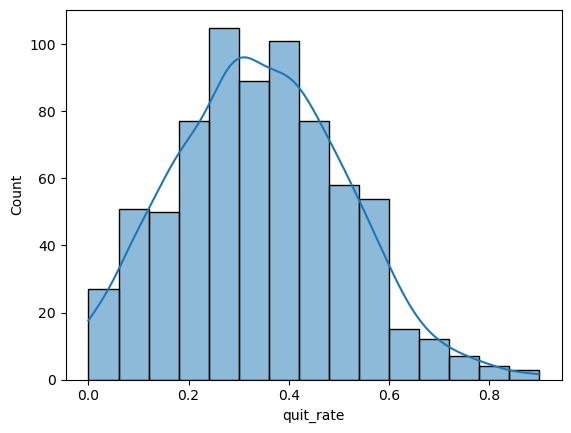

In [29]:
sns.histplot(data=quitting_rates["quit_rate"], kde=True, bins=15)

# 2. Back-click rate distribution

In [32]:
tmp_finished = finished.copy()
tmp_unfinished = unfinished.copy()
tmp_finished["finished"] = True
tmp_unfinished["finished"] = False

backclicks_df = pd.concat([tmp_finished, tmp_unfinished], ignore_index=True)[["hashedIpAddress", "readable_path", "finished"]]

# Compute backclicked and visited pages
backclicks_df["backclicked_pages"] = backclicks_df["readable_path"].apply(lambda x: get_backclicked_pages(x))
backclicks_df["visited_pages"] = backclicks_df["readable_path"].apply(lambda x: [el for el in x if el != "<"])

# Compute backclick rate for each game
backclicks_df["backclick_freq"] = backclicks_df["backclicked_pages"].apply(lambda x: len(x) if x is not pd.NA else 0) / backclicks_df["visited_pages"].apply(lambda x: len(x))


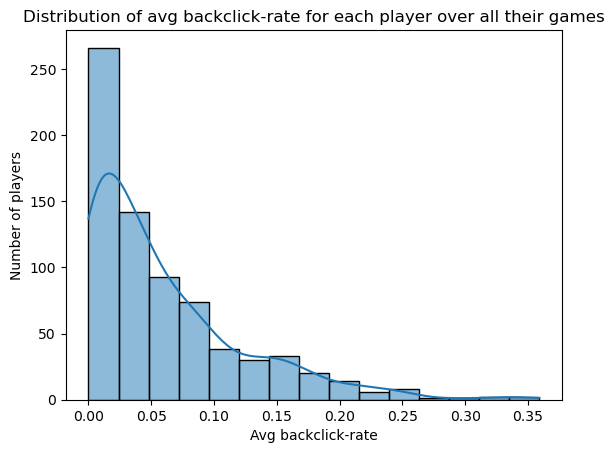

In [33]:
sns.histplot(data=backclicks_df[["hashedIpAddress", "backclick_freq"]].groupby("hashedIpAddress").mean()["backclick_freq"],
             kde=True,
             bins=15)
plt.title("Distribution of avg backclick-rate for each player over all their games")
plt.xlabel("Avg backclick-rate")
plt.ylabel("Number of players")
plt.show()

# 3. Backclick-rate per category

#### We define ***backclick rate*** of a player on a category, as the number of times that player has backclicked a page of that category, over the total number he/she visited pages of that category. Or in other words, the how likely that player is to backclick a page of that category

In [34]:
# Create a dataframe to count the number of backclicks and visits for each category
backclicks_df["visited_categories"] = backclicks_df["visited_pages"].apply(lambda x: [article_to_broad_category[page][0] for page in x if page in article_to_broad_category.keys()])
backclicks_df["backclicked_categories"] = backclicks_df["backclicked_pages"].apply(lambda x: [article_to_broad_category[page][0] for page in x if page in article_to_broad_category.keys()]
                                                                                        if x is not pd.NA else pd.NA)
backclicks_per_category = pd.merge(
    backclicks_df[["hashedIpAddress", "visited_categories", "finished"]].explode("visited_categories").groupby(["hashedIpAddress", "visited_categories", "finished"]).size().reset_index(name="visits_count"),
    backclicks_df[["hashedIpAddress", "backclicked_categories", "finished"]].explode("backclicked_categories").groupby(["hashedIpAddress", "backclicked_categories", "finished"]).size().reset_index(name="backclicks_count"),
    how="left",
    left_on=["hashedIpAddress", "visited_categories", "finished"],
    right_on=["hashedIpAddress", "backclicked_categories", "finished"],
)

backclicks_per_category.drop(columns=["backclicked_categories"], inplace=True)
backclicks_per_category.rename(columns={"visited_categories": "category"}, inplace=True)
backclicks_per_category["backclicks_count"].fillna(0, inplace=True)
backclicks_per_category["backclick_rate_per_category"] = backclicks_per_category["backclicks_count"] / backclicks_per_category["visits_count"]

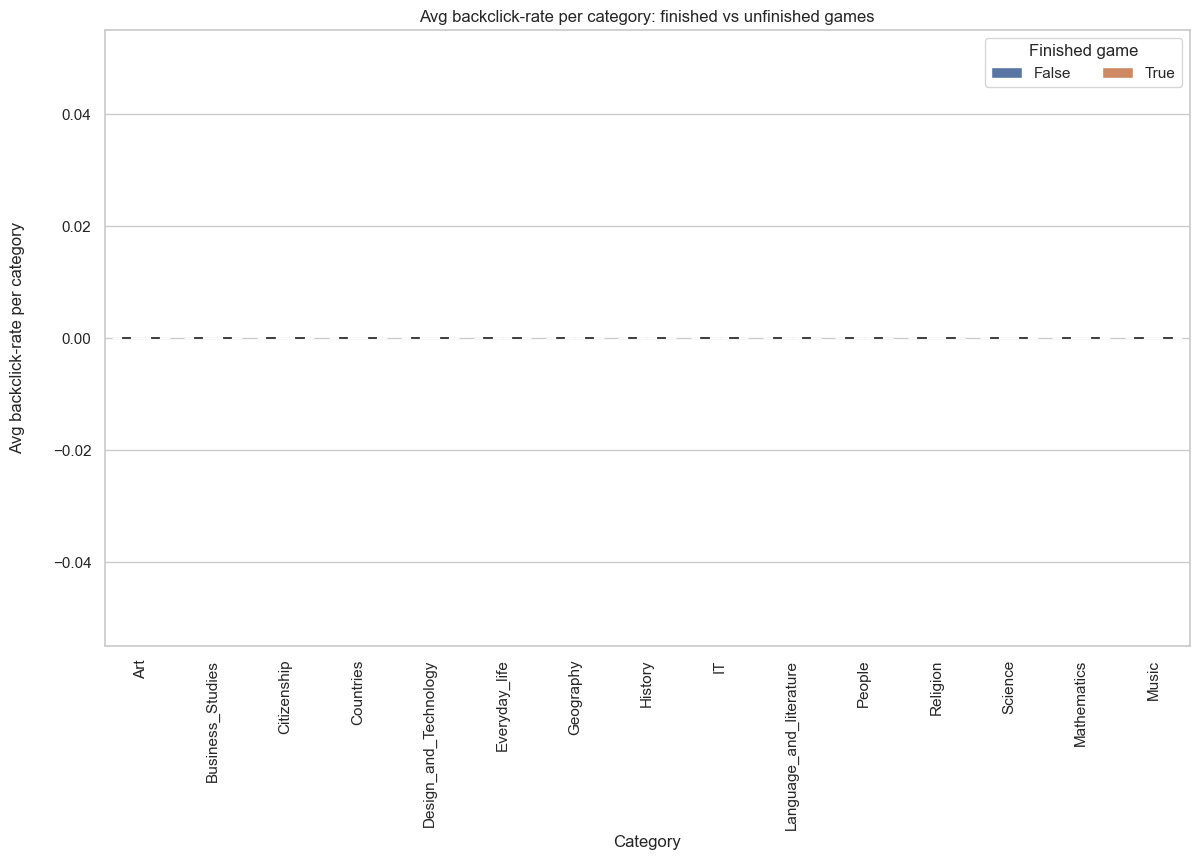

In [42]:
plt.figure(figsize=(14, 8))
sns.barplot(data=backclicks_per_category[["category", "finished", "backclick_rate_per_category"]],
            x="category",
            y="backclick_rate_per_category",
            hue="finished",
            errorbar=("ci", 95),
            errwidth=1.4,
            capsize=0.1,
            estimator=np.median,)
plt.xticks(rotation=90)
plt.title("Avg backclick-rate per category: finished vs unfinished games")
plt.ylabel("Avg backclick-rate per category", labelpad=20)
plt.xlabel("Category")
plt.legend(title="Finished game", ncols=2)
plt.show()

# 4. Quit vs. Backclicks

### Is there a link between the categories on which the player backclicked and the ones on which he/she quitted?
Let's now do a hypothesis test to see whether the quitting rate is significantly different for players who backclick a lot vs. players who don't backclick a lot.

For this purpose we will use a chi-squared test, with:
- $H_0$: the probability of quitting and the probability of backclicking are independent
- $H_1$: the probability of quitting and the probability of backclicking are not independent

In [36]:
intervals = [0, 0.0675, 0.125, 0.1875, 0.25, 0.5, 1]
backclicks_df["backclick_freq_interval"] = pd.cut(backclicks_df["backclick_freq"], bins=intervals, include_lowest=True)

contingency_table = pd.crosstab(backclicks_df["backclick_freq_interval"], backclicks_df["finished"])

chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Output the results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
alpha = 0.05
if p < alpha:
    print("\n-> Reject the null hypothesis. There is a significant relationship.")
else:
    print("\n-> Fail to reject the null hypothesis. There is no significant relationship.")


Chi-squared statistic: 507.596638248585
P-value: 1.8300022831380184e-107

-> Reject the null hypothesis. There is a significant relationship.


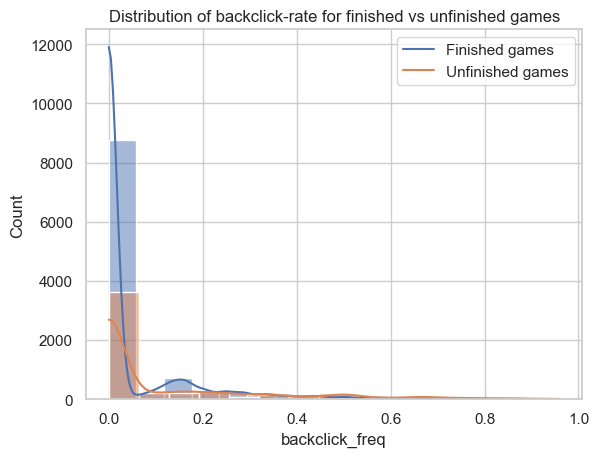

In [37]:
sns.set_theme(style="whitegrid")
sns.histplot(backclicks_df[backclicks_df["finished"] == True]["backclick_freq"], kde=True, bins=15)
sns.histplot(backclicks_df[backclicks_df["finished"] == False]["backclick_freq"], kde=True, bins=15)
plt.legend(["Finished games", "Unfinished games"])
plt.title("Distribution of backclick-rate for finished vs unfinished games")
plt.show()

In the previous point we've considered every game as independent by other games, but it could be interesting to see if we can get the same result aggregating the back-click frequency of all the games of the same player

In [38]:
# Aggregate the backclick rate for each player over all their games
backclicks_df = backclicks_df.groupby(by=["hashedIpAddress", "finished"])["backclick_freq"].aggregate("mean").reset_index()
backclicks_df["backclick_freq_interval"] = pd.cut(backclicks_df["backclick_freq"], bins=intervals, include_lowest=True)

contingency_table = pd.crosstab(backclicks_df["backclick_freq_interval"], backclicks_df["finished"])

chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Output the results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
alpha = 0.05
if p < alpha:
    print("\n-> Reject the null hypothesis. There is a significant relationship.")
else:
    print("\n-> Fail to reject the null hypothesis. There is no significant relationship.")

Chi-squared statistic: 218.31679077645282
P-value: 3.40811948432458e-45

-> Reject the null hypothesis. There is a significant relationship.



---


<a id="backclicks-analysis"></a>

#### 3.7 - Back-clicking influence on finished vs. unfinished paths

##### For the following analyses, we will only consider players who palyed at least 10 games and exclude all games shorter than 2 clicks.

In [ ]:
# Filter games keeping only data collected from players who played at least 10 games, considering only paths with at least 2 clicks.
bck_an_finished, bck_an_unfinished = filter_games(finished_paths, unfinished_paths, min_games=10, min_length=2, type="restart")

<a id="bck-distr"></a>
##### 3.7.1. Back-clicks frequency distribution
Let's first visualize the distribution of the average backclick frequency, i.e. the average over all the games a user played of the number of backclicks over the path's length

In [ ]:
# Concatenate the two dataframes
bck_an_all = pd.concat([
    bck_an_finished.assign(finished=True),
    bck_an_unfinished.assign(finished=False)
], ignore_index=True)[["hashedIpAddress", "path", "finished"]]

# Compute backclicked and visited pages (i.e. path without the "<")
bck_an_all["backclicked_pages"] = bck_an_all["path"].apply(lambda x: get_backclicked_pages(x))
bck_an_all["visited_pages"] = bck_an_all["path"].apply(lambda x: [el for el in x if el != "<"])

# Compute backclick frequency for each game
bck_an_all["backclick_freq"] = bck_an_all["backclicked_pages"].apply(lambda x: len(x) if x is not pd.NA else 0) / bck_an_all["visited_pages"].apply(lambda x: len(x))

In [ ]:
sns.histplot(data=bck_an_all[["hashedIpAddress", "backclick_freq"]].groupby("hashedIpAddress").mean()["backclick_freq"],
             kde=True,
             bins=15)
plt.title("Distribution of avg backclick frequency for each player over all their games")
plt.xlabel("Avg backclick-rate")
plt.ylabel("Number of players")
plt.show()

<a id=bck-freq-compare></a>
#### 3.7.2 Back-click frequency distribution in finished vs unfinished paths

In [ ]:
# Create a dataframe to count the number of backclicks and visits for each category
bck_an_all["visited_categories"] = bck_an_all["visited_pages"].apply(lambda x: [article_to_broad_category[page][0] for page in x if page in article_to_broad_category.keys()])
bck_an_all["backclicked_categories"] = bck_an_all["backclicked_pages"].apply(lambda x: [article_to_broad_category[page][0] for page in x if page in article_to_broad_category.keys()]
                                                                                        if x is not pd.NA else pd.NA)

plt.figure(figsize=(12, 5))
sns.histplot(bck_an_all[bck_an_all["finished"] == True].groupby("hashedIpAddress")["backclick_freq"].mean(), kde=True, alpha=0.5)
sns.histplot(bck_an_all[bck_an_all["finished"] == False].groupby("hashedIpAddress")["backclick_freq"].mean(), kde=True, alpha=0.25)
plt.legend(["Finished games", "Unfinished games"])
plt.title("Distribution of avg backclick frequency for each player over all their games")
plt.xlabel("Avg backclick-rate")
plt.ylabel("Number of players")
plt.show()

In [ ]:
# Create a dataframe to count the number of backclicks and visits for each category
bck_an_all["visited_categories"] = bck_an_all["visited_pages"].apply(lambda x: [article_to_broad_category[page][0] for page in x if page in article_to_broad_category.keys()])
bck_an_all["backclicked_categories"] = bck_an_all["backclicked_pages"].apply(lambda x: [article_to_broad_category[page][0] for page in x if page in article_to_broad_category.keys()]
                                                                                        if x is not pd.NA else pd.NA)

plt.figure(figsize=(12, 5))
plt.hist(bck_an_all[bck_an_all["finished"] == True].groupby("hashedIpAddress")["backclick_freq"].mean(), density=True, alpha=0.5, bins=25)
plt.hist(bck_an_all[bck_an_all["finished"] == False].groupby("hashedIpAddress")["backclick_freq"].mean(), density=True, alpha=0.25, bins=25)
plt.legend(["Finished games", "Unfinished games"])
plt.title("Distribution of avg backclick frequency for each player over all their games")
plt.xlabel("Avg backclick-rate")
plt.ylabel("Number of players")
plt.show()

<a id=bck-rate-cat></a>
#### 3.7.3 Back-click rate per category

Now, we define the **back-click rate per category** $c$ for a player $P$ as the number of times that $P$ has baclicked on a page that belongs to the category $c$, divide by the number of times $P$ visited a page of that category. This measure should express how likely is the player $P$ to back-click a page of category $c$.

In [ ]:
backclicks_per_category = pd.merge(
    bck_an_all[["hashedIpAddress", "visited_categories", "finished"]].explode("visited_categories").groupby(["hashedIpAddress", "visited_categories", "finished"]).size().reset_index(name="visits_count"),
    bck_an_all[["hashedIpAddress", "backclicked_categories", "finished"]].explode("backclicked_categories").groupby(["hashedIpAddress", "backclicked_categories", "finished"]).size().reset_index(name="backclicks_count"),
    how="left",
    left_on=["hashedIpAddress", "visited_categories", "finished"],
    right_on=["hashedIpAddress", "backclicked_categories", "finished"],
)

backclicks_per_category.drop(columns=["backclicked_categories"], inplace=True)
backclicks_per_category.rename(columns={"visited_categories": "category"}, inplace=True)
backclicks_per_category["backclicks_count"].fillna(0, inplace=True)
backclicks_per_category["backclick_rate_per_category"] = backclicks_per_category["backclicks_count"] / backclicks_per_category["visits_count"]

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(data=backclicks_per_category[["category", "finished", "backclick_rate_per_category"]],
            x="category",
            y="backclick_rate_per_category",
            hue="finished",
            order=backclicks_per_category[backclicks_per_category["finished"] == False][["category", "backclick_rate_per_category"]].groupby("category").mean().sort_values(by="backclick_rate_per_category", ascending=False).index,
            hue_order=[True, False],
            errorbar=("ci", 95),
            errwidth=1.4,
            capsize=0.1,
            estimator=np.mean,)
plt.xticks(rotation=80)
plt.title("Avg backclick-rate per category: finished vs unfinished games")
plt.ylabel("Avg backclick-rate per category", labelpad=20)
plt.xlabel("Category", labelpad=20)
plt.legend(title="Finished game", ncols=2)
plt.show()

The bar chart shows that the average back-click rate is often significantly different for finished and unfinished paths.
Since this data compare finished and unfinished per-category backclicl-rate of all players, we could see that it's likely that a player with a high back-click rate will quit, even if the measure of how likely is this case, depends on the category.

<a id=bck-rate-cat></a>
#### 3.7.4 Back-click frequency impact on finishing the game

Let's do a hypothesis test to see whether a higher back-click frequency is linked to whether or not the player will reach the target page.<br>
More formally, we want to test whether the random variables $X$=*"the player reaches the target"* and $Y$=*"interval of value for back-click frequency"* are independant or not.

For this purpose we will use a chi-squared test, with:
- $H_0$: the probability of quitting and the probability of backclicking are independent
- $H_1$: the probability of quitting and the probability of backclicking are not independent

In [ ]:
intervals = [0, 0.0675, 0.125, 0.1875, 0.25, 0.5, 1]
bck_an_all["backclick_freq_interval"] = pd.cut(bck_an_all["backclick_freq"], bins=intervals, include_lowest=True)

contingency_table = pd.crosstab(bck_an_all["backclick_freq_interval"], bck_an_all["finished"])

chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Output the results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
alpha = 0.05
if p < alpha:
    print("\n-> Reject the null hypothesis. There is a significant relationship.")
else:
    print("\n-> Fail to reject the null hypothesis. There is no significant relationship.")


In [ ]:
# TODO: add comment

In [ ]:
# Aggregate the backclick rate for each player over all their games
bck_an_all = bck_an_all.groupby(by=["hashedIpAddress", "finished"])["backclick_freq"].aggregate("mean").reset_index()
bck_an_all["backclick_freq_interval"] = pd.cut(bck_an_all["backclick_freq"], bins=intervals, include_lowest=True)

contingency_table = pd.crosstab(bck_an_all["backclick_freq_interval"], bck_an_all["finished"])

chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Output the results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
alpha = 0.05
if p < alpha:
    print("\n-> Reject the null hypothesis. There is a significant relationship.")
else:
    print("\n-> Fail to reject the null hypothesis. There is no significant relationship.")